# Step 0: Init the AutoML program

In [1]:
import numpy as np
import os
import contextlib
import tensorflow as tf
import tempfile
import shutil
import zipfile
from PIL import Image
import numpy as np
import zipfile


@contextlib.contextmanager
def _tempdir():
    dirpath = tempfile.mkdtemp()
    print(f"create temp: {dirpath}")
    yield dirpath
    print(f"delete temp: {dirpath}")
    shutil.rmtree(dirpath)


class ImageClassifier:
    def __init__(self):
        self.model = None
        self.image_size = None
        self.class_names = None

    def train(self, train_dir, validation_dir=None, batch_size=32, epochs=1, image_size=(160, 160)):
        # Step1: Data prep
        train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                                    shuffle=True,
                                                                    batch_size=batch_size,
                                                                    image_size=image_size)
        validation_dataset = None
        if validation_dir:
            validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                             shuffle=True,
                                                                             batch_size=batch_size,
                                                                             image_size=image_size)
        class_names = train_dataset.class_names

        print('Number of trian batches: %d' %
              tf.data.experimental.cardinality(train_dataset))
        if validation_dataset:
            print('Number of validation batches: %d' %
                  tf.data.experimental.cardinality(validation_dataset))
        AUTOTUNE = tf.data.AUTOTUNE
        train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
        if validation_dataset:
            validation_dataset = validation_dataset.prefetch(
                buffer_size=AUTOTUNE)

        # Step2: Model Architecture
        # data_augmentation = tf.keras.Sequential([
        #     tf.keras.layers.RandomFlip('horizontal'),
        #     tf.keras.layers.RandomRotation(0.2),
        # ])
        preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
        image_shape = image_size + (3,)
        base_model = tf.keras.applications.MobileNetV2(input_shape=image_shape,
                                                       include_top=False,
                                                       weights='imagenet')
        base_model.trainable = True
        fine_tune_at = 100
        for layer in base_model.layers[:fine_tune_at]:
            layer.trainable = False

        global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
        prediction_layer = tf.keras.layers.Dense(len(class_names))
        inputs = tf.keras.Input(shape=image_shape)
        x = inputs
        # x = data_augmentation(x)
        x = preprocess_input(x)
        x = base_model(x, training=False)
        x = global_average_layer(x)
        x = tf.keras.layers.Dropout(0.2)(x)
        outputs = prediction_layer(x)
        model = tf.keras.Model(inputs, outputs)
        base_learning_rate = 0.0001
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
                      loss=tf.keras.losses.SparseCategoricalCrossentropy(
            from_logits=True),
            metrics=['accuracy'])
        model.summary()

        # Step 3: Start training
        history = model.fit(train_dataset,
                            epochs=epochs,
                            validation_data=validation_dataset)

        # Step 4: Evaluation
        if validation_dataset:
            loss, accuracy = model.evaluate(validation_dataset)
            print('Test accuracy :', accuracy)

            # Retrieve a batch of images from the test set
            image_batch, label_batch = validation_dataset.as_numpy_iterator().next()
            predictions = model.predict_on_batch(image_batch)

            # Apply softmax and argmax to find the most possible class
            predictions = model.predict_on_batch(image_batch)
            predictions = tf.nn.softmax(predictions)
            predictions = tf.math.argmax(predictions, axis=-1)
            print('Predictions:\n', predictions.numpy())
            print('Labels:\n', label_batch)

        self.model = model
        self.class_names = class_names
        self.image_size = (160, 160)
        image_size = (160, 160)

        return history

    def save(self, modelfile):
        with _tempdir() as modelpath:
            self.model.save(modelpath)
            with open(f'{modelpath}/class_names.txt', 'w') as f:
                for class_name in self.class_names:
                    print(class_name, file=f)

            with zipfile.ZipFile(modelfile, 'w', zipfile.ZIP_DEFLATED) as zf:
                for dirname, subdirs, files in os.walk(modelpath):
                    arc_dirname = dirname[len(modelpath):]
                    print(f'dir : {arc_dirname}/')
                    zf.write(dirname, arc_dirname)
                    for filename in files:
                        print(f'file: {arc_dirname}/{filename}')
                        zf.write(os.path.join(dirname, filename),
                                 os.path.join(arc_dirname, filename))

    def load(self, modelfile):
        with _tempdir() as dirpath:
            with zipfile.ZipFile(modelfile, 'r') as zip_ref:
                zip_ref.extractall(dirpath)
            model = tf.keras.models.load_model(dirpath)
            with open(f"{dirpath}/class_names.txt") as f:
                class_names = f.readlines()
            class_names = [class_name.strip() for class_name in class_names]

        self.image_size = (160, 160)
        self.class_names = (class_names)
        self.model = model

    def predict(self, img_path):
        with Image.open(img_path) as image:
            image = image.resize(self.image_size)
            x = tf.keras.preprocessing.image.img_to_array(image)
            x = tf.expand_dims(x, 0)
        result = tf.math.argmax(tf.nn.softmax(self.model(x)), axis=-1)
        print(self.class_names[int(result)])


# Step 1: Prepare the dataset

The dataset should be a 'zip' file with the following format.

```
flowers_photos/
  daisy/
  dandelion/
  roses/
  sunflowers/
  tulips/
```  

Please see the document in tensorflow
https://www.tensorflow.org/tutorials/load_data/images


There are two way to prepare the dataset

1. Load from local file
1. Download from public url

## Load Dataset from local file

In [27]:
_DATASET_FILE = '/content/cats_and_dogs_50.zip'

# from google.colab import files
# uploaded = files.upload()
# for fn in uploaded.keys():
#   _DATASET_FILE=fn

import os
import tempfile

with zipfile.ZipFile(_DATASET_FILE, 'r') as zip_ref:
    zip_ref.extractall(".")

basename = os.path.basename(_DATASET_FILE)
base, ext = os.path.splitext(basename)
train_dir = f'{base}/train'
validation_dir = f'{base}/validation'

print(f"train dir: {train_dir}")
print(f"validation dir: {validation_dir}")

train dir: cats_and_dogs_50/train
validation dir: cats_and_dogs_50/validation


## Download Dataset from Public URL

In [22]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'

import os

basename = os.path.basename(_URL)
base, ext = os.path.splitext(basename)
path_to_zip = tf.keras.utils.get_file(basename, origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), base)
train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')
print(f"train dir: {train_dir}")
print(f"validation dir: {validation_dir}")

train dir: /root/.keras/datasets/cats_and_dogs_filtered/train
validation dir: /root/.keras/datasets/cats_and_dogs_filtered/validation


# Step 2: Train

In [28]:
BATCH_SIZE = 32
EPOCHS = 2
IMG_SIZE = (160, 160)


classifier =  ImageClassifier()
classifier.train(train_dir, validation_dir, epochs=EPOCHS, image_size=IMG_SIZE)

Found 100 files belonging to 2 classes.
Found 20 files belonging to 2 classes.
Number of trian batches: 4
Number of validation batches: 1
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 tf.math.truediv_2 (TFOpLamb  (None, 160, 160, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_2 (TFOpLam  (None, 160, 160, 3)      0         
 bda)                                                            
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                     

# Step 3: Predict

dogs


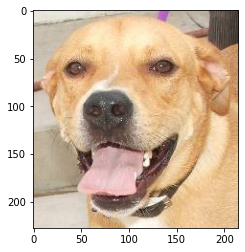

In [34]:
import matplotlib.pyplot as plt
import matplotlib.image as img

_IMG_PATH="/content/cats_and_dogs_50/validation/dogs/dog.2001.jpg"

# from google.colab import files
# uploaded = files.upload()
# for fn in uploaded.keys():
#   _IMG_PATH=fn

image = img.imread(_IMG_PATH)
predict = classifier.predict(_IMG_PATH)

plt.title(predict)
plt.imshow(image)
plt.show()

# Step 4: Save and Load

## Save the model

In [29]:
!mkdir -p models
_MODEL_FILE="models/cats_and_dogs.zip"

classifier.save(_MODEL_FILE)

mkdir: cannot create directory ‘models’: File exists
create temp: /tmp/tmpzm_60cat
INFO:tensorflow:Assets written to: /tmp/tmpzm_60cat/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


dir : /
file: /keras_metadata.pb
file: /class_names.txt
file: /saved_model.pb
dir : /variables/
file: /variables/variables.index
file: /variables/variables.data-00000-of-00001
dir : /assets/
delete temp: /tmp/tmpzm_60cat


## Load the model

In [30]:
_MODEL_FILE="models/cats_and_dogs.zip"

classifier=ImageClassifier()
classifier.load(_MODEL_FILE)


create temp: /tmp/tmpflat0v53
delete temp: /tmp/tmpflat0v53
